# Ford GoBike System Data

## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.
In this project, an exploratory analysis will be done over Ford GoBike data, a bike-share system provider.

## Preliminary Wrangling

+ Source data : https://www.fordgobike.com/system-data
+ It includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.
+ Multiple data files will need to be joined together in case a full year’s coverage is needed. In this project, we will focus on the record of individual trips taken in from June, 2018 to May, 2019.

+ The features included in this dataset : Trip Duration (seconds) , Start Time and Date , End Time and Date , Start Station ID , Start Station Name , Start Station Latitude , Start Station Longitude , End Station ID , End Station Name, End Station Latitude , End Station Longitude , Bike ID , User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual) , Member Year of Birth, Member Gender

In [3]:
# import all packages and set plots to be embedded inline
import os
import time
import glob
import numpy as np
import pandas as pd
import helpers as hp
import plotly.graph_objects as go

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [4]:
# Reading all csv files at once and append them at one dataframe
path = r"D:\GitLabRepos\GoBike\gobike"
all_files = glob.glob(os.path.join(path, "*.csv"))
print("Concatincating files to one file...")
start_time = time.time()
df = pd.concat(
    (pd.read_csv(
        file, parse_dates=['start_time', 'end_time', 'member_birth_year'],
        dtype={"start_station_id":"O", "end_station_id":"O", "bike_id":"O"},
        memory_map=True
    ) for file in all_files), ignore_index=True
)
end_time = time.time()
print("done!")
print("It tooks {} seconds to read and concatnate datasets".format(round(end_time - start_time, 2)))

Concatincating files to one file...
done!
It tooks 11.02 seconds to read and concatnate datasets


In [5]:
# Taking a sample of the main dataframe since it has more than two millions rows  
df_sample = df.sample(500000)
df_sample.head()

duration_sec              start_time                end_time  \
823455            637 2018-10-24 08:36:26.611 2018-10-24 08:47:04.168   
476534            588 2018-08-18 15:55:46.063 2018-08-18 16:05:34.598   
1537817           305 2019-02-14 07:31:14.469 2019-02-14 07:36:19.715   
1983234           197 2019-04-13 14:43:37.828 2019-04-13 14:46:55.512   
595084            452 2018-09-29 11:12:39.042 2018-09-29 11:20:12.001   

        start_station_id          start_station_name  start_station_latitude  \
823455                74       Laguna St at Hayes St               37.776435   
476534                41  Golden Gate Ave at Polk St               37.781270   
1537817              108        16th St Mission BART               37.764710   
1983234              266      Parker St at Fulton St               37.862464   
595084                37         2nd St at Folsom St               37.785000   

         start_station_longitude end_station_id           end_station_name  \
823455               -122.426244             79       7th St at Brannan St   
476534               -122.418740             74      Laguna St at Hayes St   
1537817              -122.419957            112     Harrison St at 17th St   
1983234              -122.264791            240  Haste St at Telegraph Ave   
595084               -122.395936             50      2nd St at Townsend St   

         end_station_latitude  end_station_longitude bike_id   user_type  \
823455              37.773492            -122.403672    1597  Subscriber   
476534              37.776435            -122.426244     523  Subscriber   
1537817             37.763847            -122.413004    4953  Subscriber   
1983234             37.866043            -122.258804    4791  Subscriber   
595084              37.780526            -122.390288    2237    Customer   

        member_birth_year member_gender bike_share_for_all_trip  
823455         1995-01-01          Male                      No  
476534         1959-01-01          Male                     Yes  
1537817        1987-01-01          Male                      No  
1983234        1970-01-01          Male                      No  
595084         1959-01-01        Female                      No

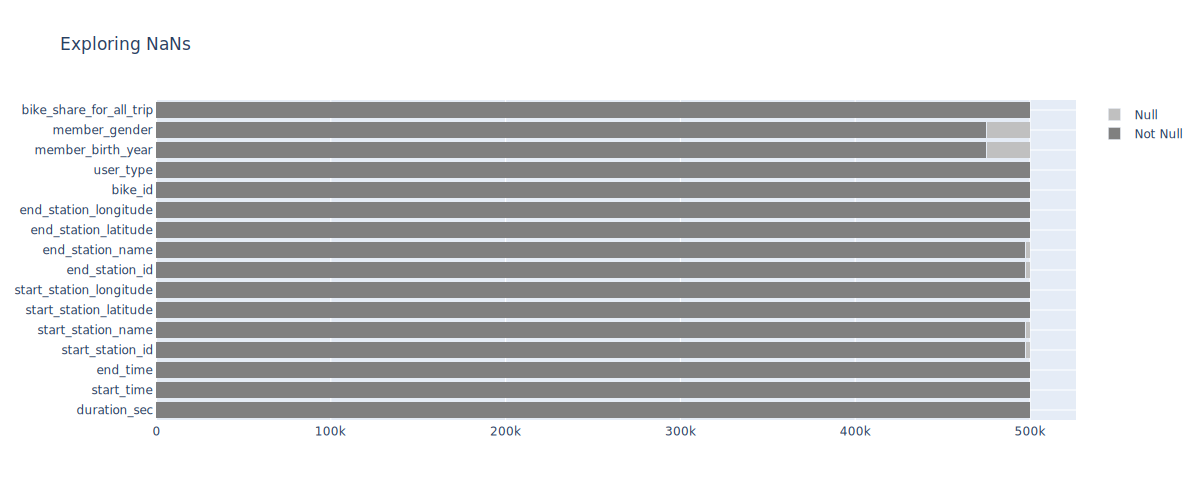

In [6]:
# exploring NaNs
hp.explore_nans(df_sample, "Exploring NaNs")

In [7]:
# do some data cleaning : drop nan , remove some insignificant features, adding trip duration in minutes feature 
df_sample.drop(['start_station_latitude','start_station_longitude', 'end_station_latitude', 'end_station_longitude'], axis=1, inplace=True)
df_sample.dropna(inplace=True)
df_sample["duration_min"] = df_sample["duration_sec"] / 60

In [8]:
df_sample.shape

(472534, 13)

### What is the structure of your dataset?

> It has a shape of 12 columns and 2167409 rows after concatinating the 12-months data files available

### What is/are the main feature(s) of interest in your dataset?

>  
+ What is the average trip duration?
+ Is whether a factor of interest to affect on trip duration?
+ Does this depend opon user type (customer/subscriber)

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> 'duration_sec', 'start_time', 'end_time', 'user_type', 'member_gender'

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

Question 1 : How long does the average trip take?

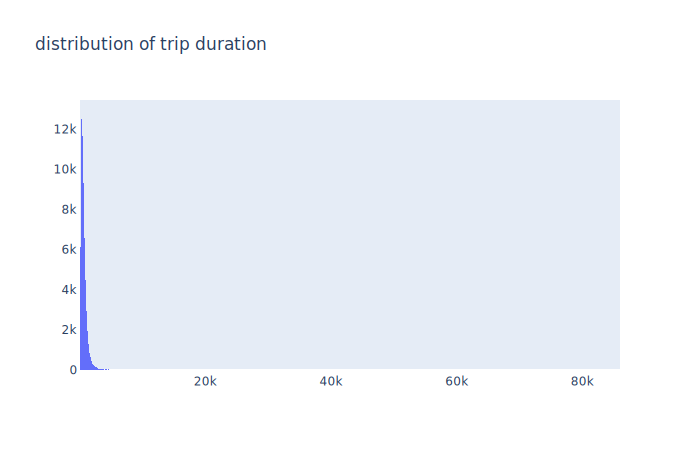

In [9]:
# Let's plot the distribution of trip duration.  
data = go.Histogram(x=df_sample["duration_sec"])
layout = go.Layout(
    title="distribution of trip duration", xaxis={"showgrid":False}, yaxis= {"showgrid":False}
)
fig = go.Figure(data, layout)
fig.show(renderer="svg")

In [10]:
data = go.Box(y=df_sample["duration_sec"], name="Trip Durations in seconds")
layout = go.Layout(
    title="distribution of trip duration", xaxis={"showgrid":False}, yaxis= {"showgrid":False}
)
fig = go.Figure(data, layout)
fig.show(renderer="svg")

> + From the two charts above, I can see a right skewed with a long tail on the right meaning that the data has a low variance.
> + Although these distribution charts showed us the shape of the data, they're still not enough to interpret and they need more percise look. A way to enhance this is to use log transformation which will be done on the next cell.
> + Measuring trip using seconds is not reasonable. I would change the `duration_sec` to `duration_min` before I add any log transformation.

In [20]:
df_sample['duration_min_log'] = np.log10(df_sample['duration_min'])

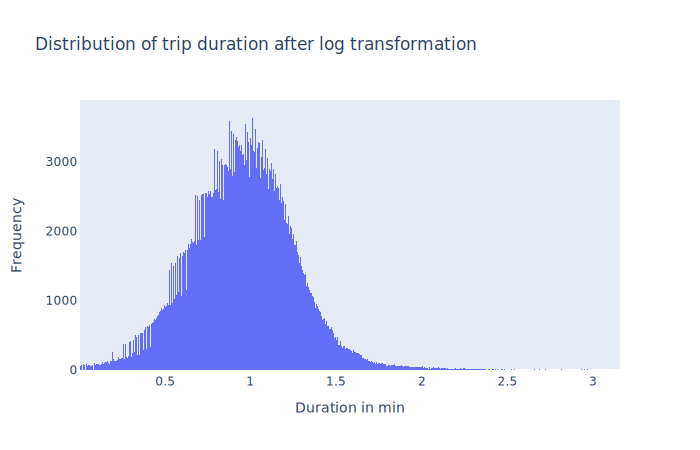

In [22]:
# Let's plot the distribution of trip duration.  
data = go.Histogram(x=df_sample["duration_min_log"])
layout = go.Layout(
    title="Distribution of trip duration after log transformation",
    xaxis={"showgrid":False, "title":"Duration in min"},
    yaxis= {"showgrid":False, "title":"Frequency"}
)
fig = go.Figure(data, layout)
fig.show(renderer="svg")

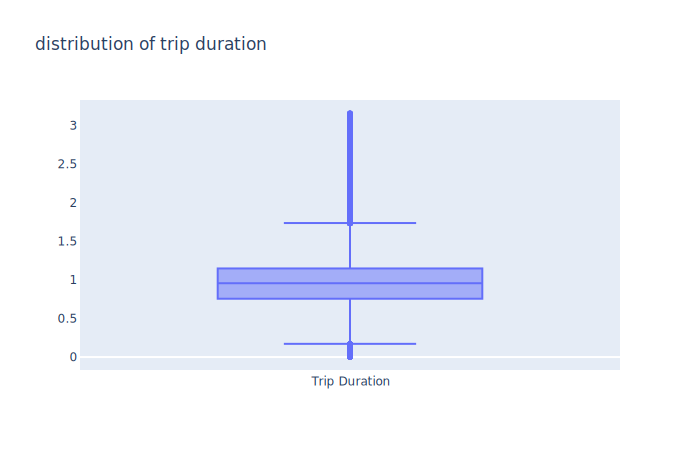

In [23]:
data = go.Box(y=df_sample["duration_min_log"], name="Trip Duration")
layout = go.Layout(
    title="distribution of trip duration", xaxis={"showgrid":False}, yaxis= {"showgrid":False}
)
fig = go.Figure(data, layout)
fig.show(renderer="svg")

> **we can see through the plot, most people tend to use the bikes for short-time trips ( around 10 mins).**

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> the varibale that I use to answer the above question was really difficult to look at the plot, so I transform the duration_sec variable to a new variable which is duration_min

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Yes, I introduced new varaible that extracted from the duration_sec variable. 

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [13]:
# some data engineering should be conducted: 
# create month_start column by extracting months of start_time 

df_trip_copy['month_start'] = pd.DatetimeIndex(df_trip_copy['start_time']).month
df_trip_copy['month_start'].value_counts()


#method 2 to extract year, month, date
#df['start_time'] = pd.to_datetime(df['start_time'])

#df['start_year'] = df['start_time'].dt.year
#df['start_month'] = df['start_time'].dt.month
#df['start_day'] = df['start_time'].dt.day

3     256299
4     239111
10    201458
7     199222
6     195968
8     192162
1     192082
9     186217
2     183412
5     182163
11    134135
12    131363
Name: month_start, dtype: int64

Question 2. Is the trip duration affected by weather (months)?

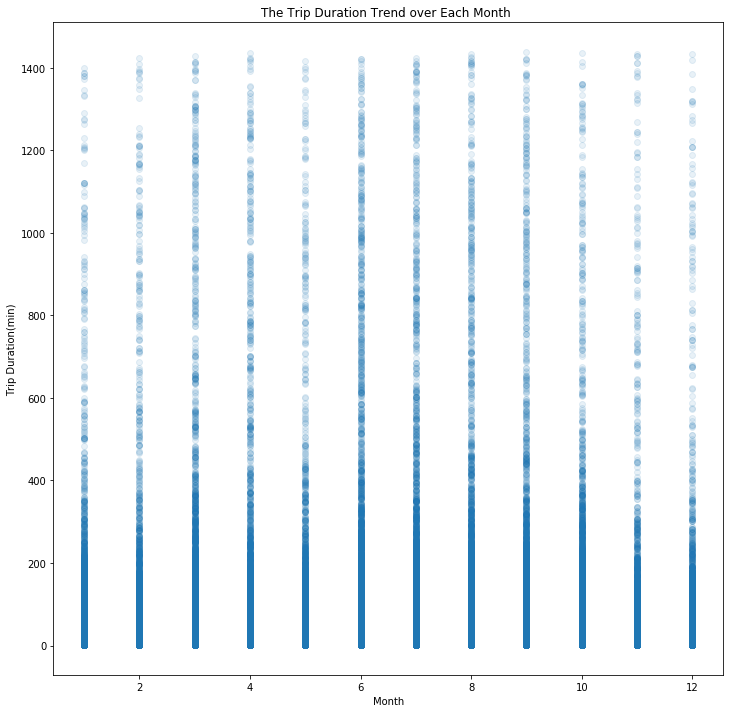

In [16]:
# We can check the trip duration over changes over each month.
plt.figure(figsize = [12,12]) # make the whole figure bigger to show all 
plt.scatter(data = df_trip_copy , x = 'month_start' , y = 'duration_min' , alpha = 0.1 )
plt.title('The Trip Duration Trend over Each Month ')
plt.xlabel('Month')
plt.ylabel('Trip Duration(min)');

June to Auguts in 2018 has the most duration. Other seasons do not have significant difference.

Question 3. Is the trip duration affected by weather (seasons)?

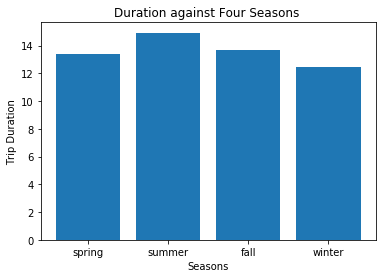

In [15]:
# Create 4 season categories
spring_dur = df_trip_copy.query('month_start in ["3" , "4" , "5"]' ).duration_min.mean ()
summer_dur = df_trip_copy.query('month_start in ["6" , "7" , "8"] ').duration_min.mean()
fall_dur = df_trip_copy.query('month_start in ["9" , "10" , "11"] ').duration_min.mean()
winter_dur = df_trip_copy.query('month_start in ["12" , "1" , "2"]' ).duration_min.mean()
# here the month must be double quote characters, otherwise, give me systax errors


plt.bar(['spring','summer','fall','winter'],[spring_dur , summer_dur , fall_dur , winter_dur] )
plt.title('Duration against Four Seasons ')
plt.xlabel('Seasons')
plt.ylabel('Trip Duration');

In [17]:
spring_dur , summer_dur , fall_dur , winter_dur

(13.364010077142751, 14.928832965580831, 13.66316596717842, 12.45105223629826)

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> + As we expected, summer has the longest trip duration , with average above 14 mins. But there is no significant difference of trip duration in terms of four seasons. It is probably because the weather in San Francisco bay area does not change that much.
+ What surprised me the most is fall has the lowest trip duration in 2018. Fall is most likely to experience good weather with pleasant average temperatures in SF. People are more likely to go out and exercise .
+ After checking the news, it is likely caused by Wildfires in Northern California(11/9/2018) which lead to the worst air quality in SF for months.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> The weather does affect trip duration, but the affect is very limited. Unlike cities like Boston, New York, which have very different four seasons, the weather in SF does not change that much.

> What surprised me is that the lower mean trip durations occur in Spring and Fall. In terms of Fall, one reason could be that the air quality in fall 2018 SF was really bad, which prevented more people doing outdoor activities. What could be the potential factor for lower trip duration in Spring ? I want to see if the user type could be a reason.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

Question 4. Does the above depend on if a user is a subscriber or customer?

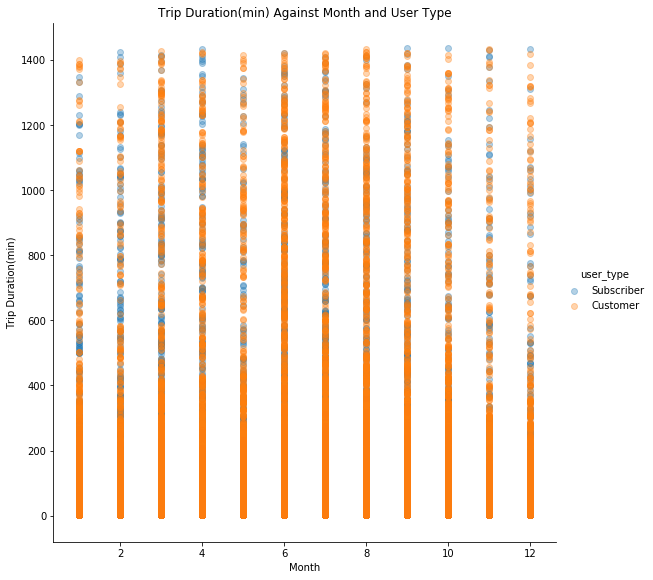

In [20]:
# I want to find out if user type lead to the lower trip duration 

g = sb.FacetGrid(data =  df_trip_copy, hue = 'user_type', height = 8)
g.map(plt.scatter, 'month_start','duration_min', alpha = 1/3)
g.add_legend()
plt.title('Trip Duration(min) Against Month and User Type')
plt.xlabel('Month')
plt.ylabel('Trip Duration(min)');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> As we can see through the plot above, there are far more customers than subscribers. The user type does make an impact on trip duration.
### Were there any interesting or surprising interactions between features?

> An interesting point is that subscribers tend to rent the bikes for long trips, above 350 minutes.



> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!